# 사전작업

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 150)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

## 데이터 로드

In [3]:
dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)
test = pd.read_csv('./data/test.csv', dtype=dtypes)

Wall time: 3min 28s


## train, test 합치기

In [6]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

194761

## Get Date - AvSigVersion

In [7]:
datedict = np.load('./data/AvSigVersionTimestamps.npy')
datedict = datedict[()]
data['Date'] = data['AvSigVersion'].map(datedict)
data['Date_YMD'] = pd.to_datetime(data['Date'].astype(str).str.slice(0, 10))
del datedict

## 2018년 7월 25일 ~ 9월 24일

### Data Load

In [9]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

In [10]:
lb_692 = pd.read_csv('./data/submission_lgb.csv')
lb_692['Date'] = test.Date.values

In [11]:
lb_701 = pd.read_csv('./data/YH_v3_new_jebal.csv')
lb_701['Date'] = test.Date.values

In [12]:
lb_702 = pd.read_csv('./data/time_test.csv')
lb_702['Date'] = test.Date.values

In [13]:
lb_706 = pd.read_csv('./data/time_test_5.csv')
lb_706['Date'] = test.Date.values

In [14]:
lb_707 = pd.read_csv('./data/time_test_7.csv')
lb_707['Date'] = test.Date.values

### make meta

In [15]:
time_idx = data.groupby(['Date']).size().index

In [16]:
temp = pd.DataFrame(time_idx)

In [22]:
condition = (temp.Date >= '2018-07-25')&(temp.Date <= '2018-11-24')

### train, test

In [23]:
tr_temp = train.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()
te_temp = test.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [24]:
tr_temp = temp.merge(tr_temp, on='Date', how='left')
te_temp = temp.merge(te_temp, on='Date', how='left')

In [25]:
tr_temp = tr_temp[condition]
te_temp = te_temp[condition]

### lb_692

In [27]:
lb_temp_692 = lb_692.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [28]:
lb_temp_692 = temp.merge(lb_temp_692, on='Date', how='left')

In [29]:
lb_temp_692 = lb_temp_692[condition]

### lb_701

In [30]:
lb_temp_701 = lb_701.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [31]:
lb_temp_701 = temp.merge(lb_temp_701, on='Date', how='left')

In [32]:
lb_temp_701 = lb_temp_701[condition]

### lb_702

In [33]:
lb_temp_702 = lb_702.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [34]:
lb_temp_702 = temp.merge(lb_temp_702, on='Date', how='left')

In [35]:
lb_temp_702 = lb_temp_702[condition]

### lb_706

In [36]:
lb_temp_706 = lb_706.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [37]:
lb_temp_706 = temp.merge(lb_temp_706, on='Date', how='left')

In [38]:
lb_temp_706 = lb_temp_706[condition]

### lb_707

In [39]:
lb_temp_707 = lb_707.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [40]:
lb_temp_707 = temp.merge(lb_temp_707, on='Date', how='left')

In [41]:
lb_temp_707 = lb_temp_707[condition]

### hypothesis

In [42]:
hypothesis_temp = train.groupby('Date').HasDetections.agg(['size', 'mean']).reset_index()

In [43]:
hypothesis_temp.Date = hypothesis_temp.Date + pd.offsets.MonthOffset(2)

In [44]:
condition = (hypothesis_temp.Date >= '2018-07-25')&(hypothesis_temp.Date <= '2018-09-24')
hypothesis_temp = hypothesis_temp[condition]

In [45]:
hypothesis_temp = temp.merge(hypothesis_temp, on='Date', how='left')

### check hypothesis

In [46]:
# check_temp = check.groupby(['Date_YMD']).HasDetections.agg(['size', 'mean']).reset_index()

In [47]:
# condition = (check_temp.Date_YMD >= '2018-07-25')&(check_temp.Date_YMD <= '2018-11-25')
# check_temp = check_temp[condition]

### plot

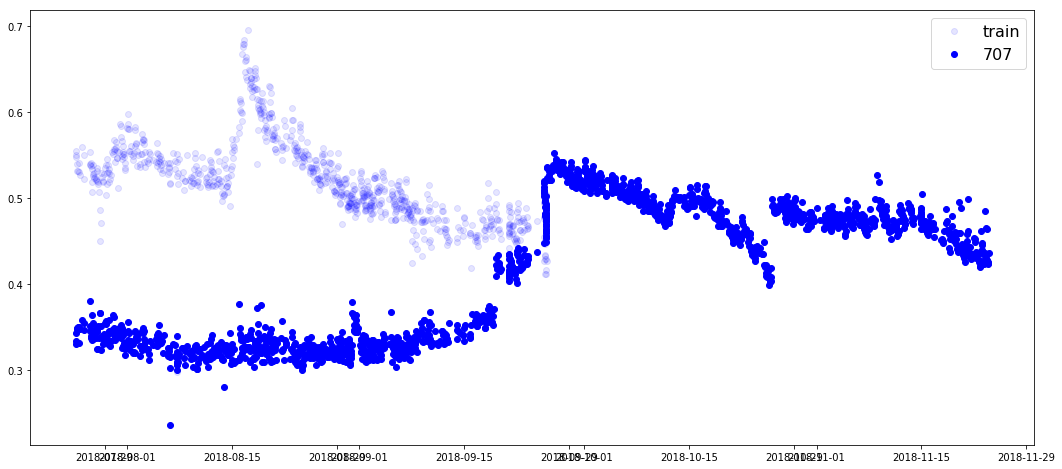

In [57]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date, tr_temp['mean'], 'o', color='b', alpha=0.1, label='train')
# plt.plot(lb_temp_692.Date, lb_temp_692['mean'], 'o', color='r', alpha=1, label='692')
# plt.plot(lb_temp_701.Date, lb_temp_701['mean'], 'o', color='g', alpha=1, label='701')
# plt.plot(lb_temp_702.Date, lb_temp_702['mean'], 'o', color='y', alpha=1, label='702')
# plt.plot(lb_temp_706.Date, lb_temp_706['mean'], 'o', color='k', alpha=1, label='706')
plt.plot(lb_temp_707.Date, lb_temp_707['mean'], 'o', color='b', alpha=1, label='707')
# plt.plot(hypothesis_temp.Date, hypothesis_temp['mean'], '+', color='c', alpha=1, label='hypothesis')
plt.legend(prop={'size': 16})

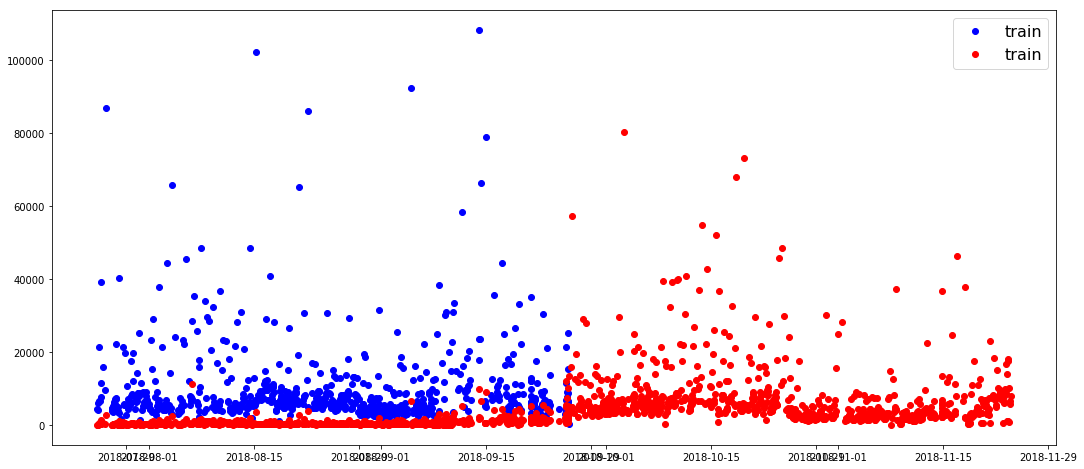

In [58]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date, tr_temp['size'], 'o', color='b', alpha=1, label='train')
plt.plot(te_temp.Date, te_temp['size'], 'o', color='r', alpha=1, label='train')
# plt.plot(hypothesis_temp.Date, hypothesis_temp['size'], 'o', color='c', alpha=1, label='train')
plt.legend(prop={'size': 16})

## 706에서 8월 22일까지를 cat으로 바꿔보기

In [180]:
change = lb_706[(lb_706.Date_YMD >= '2018-07-25') & (lb_706.Date_YMD <= '2018-08-22')]
not_change = lb_706[~((lb_706.Date_YMD >= '2018-07-25') & (lb_706.Date_YMD <= '2018-08-22'))]

In [181]:
test = cat[(cat.Date_YMD >= '2018-07-25') & (cat.Date_YMD <= '2018-08-22')]

In [182]:
change.HasDetections = test.HasDetections.values

In [183]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [188]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_7.csv', index=False)

## 706에서 9월 26일부터 11월 25일까지 Hypothesis Check으로 바꿔보기

In [178]:
change = lb_706[(lb_706.Date_YMD >= '2018-09-26') & (lb_706.Date_YMD <= '2018-11-25')]
not_change = lb_706[~((lb_706.Date_YMD >= '2018-09-26') & (lb_706.Date_YMD <= '2018-11-25'))]

In [179]:
test = test[['MachineIdentifier', 'HasDetections', 'Date_YMD']]
test = test[(test.Date_YMD >= '2018-09-26') & (test.Date_YMD <= '2018-11-25')]

In [161]:
change.HasDetections = test.HasDetections.values

In [162]:
check = change.append(not_change).sort_values('MachineIdentifier')

In [122]:
check[['MachineIdentifier', 'HasDetections']].to_csv('./data/time_test_4.csv', index=False)

# Crazy Method - 2달 미뤄서 훈련시켜보기

In [226]:
temp = data[(data.Date_YMD >= '2018-05-25') & (data.Date_YMD <= '2018-09-24')]
del temp['Date']
gc.collect()

0

In [227]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

del temp
gc.collect()

0

In [97]:
train = train[train.Date_YMD <= '2018-07-24']
test = test[test.Date_YMD >= '2018-07-25']

gc.collect()

0

In [205]:
# 2달 미루기
train.Date_YMD = train.Date_YMD + pd.offsets.MonthOffset(2)

In [228]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [229]:
train.shape

(627299, 84)

In [230]:
test.shape

(161697, 84)

In [225]:
del train['AvSigVersion'], test['AvSigVersion']
gc.collect()

7

In [231]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)

    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 50)].reset_index(drop=True)
    agg['Total'] = agg['Train'] / 3 + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / (agg['Total'] * 3) > 0.14) & (agg['Train'] / (agg['Total'] * 3) < 0.86)]
    agg[usecol+'Copy'] = agg[usecol]
        
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [232]:
train.shape

(627299, 84)

In [233]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [234]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

21

In [235]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [236]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [237]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [238]:
train.shape

(627299, 10039)

In [239]:
test.shape

(161697, 10039)

In [240]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [241]:
del ohe, train, test
gc.collect()

1162

In [242]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [243]:
train.shape

(627299, 10039)

In [244]:
test.shape

(161697, 10039)

In [246]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [247]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.677371	valid_0's binary_logloss: 0.604701
[200]	valid_0's auc: 0.685048	valid_0's binary_logloss: 0.599969
[300]	valid_0's auc: 0.687145	valid_0's binary_logloss: 0.598676
[400]	valid_0's auc: 0.687966	valid_0's binary_logloss: 0.598151
[500]	valid_0's auc: 0.688526	valid_0's binary_logloss: 0.59779
[600]	valid_0's auc: 0.688837	valid_0's binary_logloss: 0.597577
[700]	valid_0's auc: 0.689194	valid_0's binary_logloss: 0.597344
[800]	valid_0's auc: 0.68942	valid_0's binary_logloss: 0.597182
[900]	valid_0's auc: 0.689547	valid_0's binary_logloss: 0.597075
[1000]	valid_0's auc: 0.689621	valid_0's binary_logloss: 0.596991
[1100]	valid_0's auc: 0.68967	valid_0's binary_logloss: 0.596924
[1200]	valid_0's auc: 0.689712	valid_0's binary_logloss: 0.596872
[1300]	valid_0's auc: 0.689751	valid_0's binary_logloss: 0.596838
[1400]	valid_0's auc: 0.689791	valid_0's binary_logloss: 0.59680

# Crazy Method - 2달 미뤄서 훈련시켜보기 2

In [49]:
temp = data[(data.Date_YMD >= '2018-07-26') & (data.Date_YMD <= '2018-11-25')]
del temp['Date']
gc.collect()

14

In [50]:
train = temp[~temp.HasDetections.isna()]
test = temp[temp.HasDetections.isna()]

del temp
gc.collect()

0

In [51]:
train = train[train.Date_YMD <= '2018-09-25']
test = test[test.Date_YMD >= '2018-09-26']

gc.collect()

0

In [54]:
# 2달 미루기
train.Date_YMD = train.Date_YMD + pd.offsets.MonthOffset(2)

In [56]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [57]:
train.shape

(7429146, 84)

In [58]:
test.shape

(6598039, 84)

In [59]:
del train['AvSigVersion'], test['AvSigVersion']
gc.collect()

183

In [60]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook([col for col in train.columns if col not in ['HasDetections', 'MachineIdentifier']]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)

    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 960)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / (agg['Total']) > 0.2) & (agg['Train'] / (agg['Total']) < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
        
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



In [62]:
train.shape

(7429146, 83)

In [63]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [64]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

28

In [65]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [66]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train.append(test))

In [67]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [68]:
train.shape

(7429146, 6853)

In [69]:
test.shape

(6598039, 6853)

In [70]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [71]:
del ohe, train, test
gc.collect()

1148

In [72]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [75]:
train.shape

(7429146, 6853)

In [76]:
test.shape

(6598039, 6853)

In [80]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [81]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**12-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=100, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.59943	valid_0's auc: 0.732838
[200]	valid_0's binary_logloss: 0.595501	valid_0's auc: 0.736929
[300]	valid_0's binary_logloss: 0.595429	valid_0's auc: 0.736905
Early stopping, best iteration is:
[232]	valid_0's binary_logloss: 0.595378	valid_0's auc: 0.73703
predicting
Fold 2

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.599563	valid_0's auc: 0.732711
[200]	valid_0's binary_logloss: 0.595567	valid_0's auc: 0.736903
[300]	valid_0's binary_logloss: 0.59558	valid_0's auc: 0.736729
Early stopping, best iteration is:
[231]	valid_0's binary_logloss: 0.595486	valid_0's auc: 0.736931
predicting
Fold 3

fitting
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.599772	valid_0's auc: 0.732361
[200]	valid_0's binary_logloss: 0.595784	valid_0's auc: 0.73664
[300]	valid_0'

In [85]:
pd.DataFrame(lgb_test_result/3).to_csv('./data_temp/temp_11.csv')